# Imports

In [1]:
import kagglehub

path = kagglehub.dataset_download("rahmasleam/flowers-dataset")

print("Path to dataset files:", path)

100%|██████████| 219M/219M [00:04<00:00, 50.8MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/rahmasleam/flowers-dataset/versions/1


In [2]:
import os
from collections import Counter
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.efficientnet import EfficientNetB3
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam

from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Data Loading

In [3]:
root_dirs = [os.path.join(path, "flower_photos")]

data = []

for root_dir in root_dirs:
    for subdir, _, files in os.walk(root_dir):
        label = os.path.basename(subdir)
        for file in files:
            file_path = os.path.join(subdir, file)
            data.append([file_path, label])

df = pd.DataFrame(data, columns=['file_path', 'label'])

print(df.head())

                                           file_path       label
0  /root/.cache/kagglehub/datasets/rahmasleam/flo...  sunflowers
1  /root/.cache/kagglehub/datasets/rahmasleam/flo...  sunflowers
2  /root/.cache/kagglehub/datasets/rahmasleam/flo...  sunflowers
3  /root/.cache/kagglehub/datasets/rahmasleam/flo...  sunflowers
4  /root/.cache/kagglehub/datasets/rahmasleam/flo...  sunflowers


In [5]:
df = df.sample(frac=1, random_state=42).reset_index(drop=True)
df

,file_path,label
0,/root/.cache/kagglehub/datasets/rahmasleam/flo...,sunflowers
1,/root/.cache/kagglehub/datasets/rahmasleam/flo...,daisy
2,/root/.cache/kagglehub/datasets/rahmasleam/flo...,roses
3,/root/.cache/kagglehub/datasets/rahmasleam/flo...,dandelion
4,/root/.cache/kagglehub/datasets/rahmasleam/flo...,dandelion
...,...,...
3665,/root/.cache/kagglehub/datasets/rahmasleam/flo...,dandelion
3666,/root/.cache/kagglehub/datasets/rahmasleam/flo...,dandelion
3667,/root/.cache/kagglehub/datasets/rahmasleam/flo...,dandelion
3668,/root/.cache/kagglehub/datasets/rahmasleam/flo...,roses


In [6]:
dir = '/kaggle/input/flowers-dataset/flower_photos'
datagen = ImageDataGenerator(
    rescale = 1./255,
    rotation_range = 0.1,
    width_shift_range = 0.1,
    zoom_range = 0.1,
    horizontal_flip = True,
    fill_mode = 'nearest',
    validation_split = 0.2,
)

In [7]:
train_generator = datagen.flow_from_dataframe(
    dataframe = df,
    x_col='file_path',
    y_col='label',
    target_size = (224, 224),
    batch_size = 16,
    class_mode = 'categorical',
    shuffle = True,
    seed = 42,
    subset = 'training',
)

validation_generator = datagen.flow_from_dataframe(
    dataframe = df,
    x_col='file_path',
    y_col='label',
    target_size = (224, 224),
    batch_size = 16,
    class_mode = 'categorical',
    shuffle = True,
    seed = 42,
    subset = 'validation',
)

Found 2936 validated image filenames belonging to 5 classes.
Found 734 validated image filenames belonging to 5 classes.


In [8]:
label_dict = {v: k for k, v in train_generator.class_indices.items()}
label_dict

{0: 'daisy', 1: 'dandelion', 2: 'roses', 3: 'sunflowers', 4: 'tulips'}

In [9]:
class_labels = list(train_generator.class_indices.keys())

# Count images per class in train_generator
train_class_counts = Counter(train_generator.classes)
train_class_counts = {class_labels[i]: count for i, count in train_class_counts.items()}

# Count images per class in validation_generator
validation_class_counts = Counter(validation_generator.classes)
validation_class_counts = {class_labels[i]: count for i, count in validation_class_counts.items()}

# Print the results
print("Training set class counts:", train_class_counts)
print("Validation set class counts:", validation_class_counts)

Training set class counts: {'dandelion': 732, 'tulips': 633, 'roses': 511, 'sunflowers': 538, 'daisy': 522}
Validation set class counts: {'sunflowers': 161, 'daisy': 111, 'roses': 130, 'dandelion': 166, 'tulips': 166}


# Data Visualization

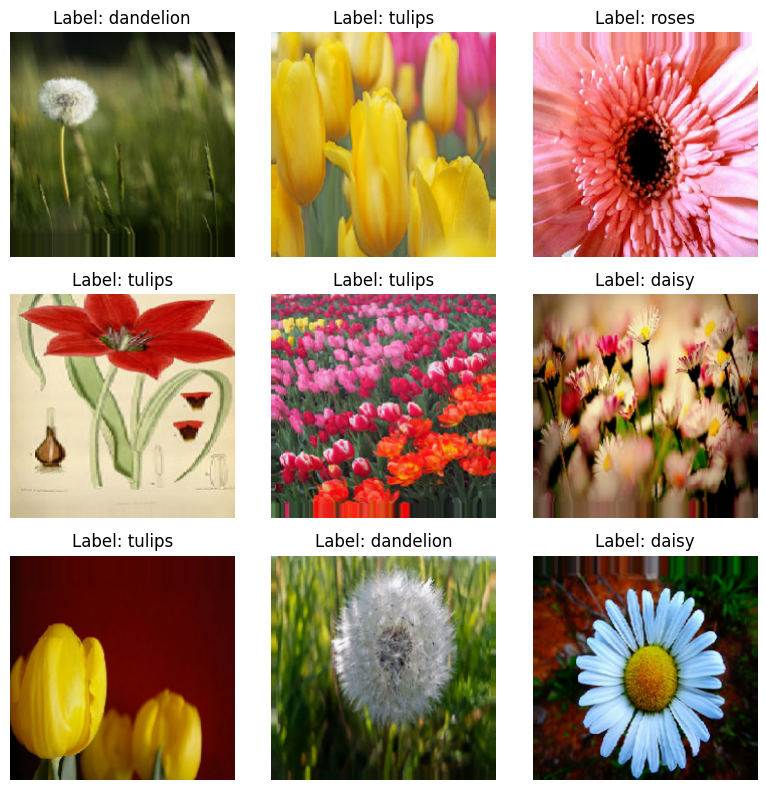

In [10]:
images, labels = next(train_generator)

num_images = 9

fig, axes = plt.subplots(3, 3, figsize=(8, 8))
axes = axes.flatten()

for i in range(num_images):
    img = images[i]

    img = (img * 255).astype(np.uint8)

    axes[i].imshow(img)
    axes[i].axis('off')
    name = np.argmax(labels[i])
    class_name = label_dict[name]
    axes[i].set_title('Label: {}'.format(class_name))

plt.tight_layout()
plt.show()

# Model Making

In [11]:
base_model = EfficientNetB3(include_top=False, weights='imagenet',
                            input_shape=(224, 224, 3), pooling=None)

model = tf.keras.models.Sequential([
    base_model,

    layers.GlobalAveragePooling2D(),

    layers.Dense(5, activation='softmax')
])

model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['acc'])

model.build(input_shape=(None, 224, 224, 3))

model.summary()

43941136/43941136 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ efficientnetb3 (Functional)          │ (None, 7, 7, 1536)          │      10,783,535 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 1536)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 5)                   │           7,685 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 10,791,220 (41.17 MB)

 Trainable params: 10,703,917 (40.83 MB)

 Non-trainable params: 87,303 (341.03 KB)

In [12]:
history = model.fit(train_generator, epochs = 5, validation_data = validation_generator)

Epoch 1/5


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


184/184 ━━━━━━━━━━━━━━━━━━━━ 290s 825ms/step - acc: 0.7247 - loss: 0.7580 - val_acc: 0.2262 - val_loss: 1.7364
Epoch 2/5
184/184 ━━━━━━━━━━━━━━━━━━━━ 59s 314ms/step - acc: 0.8523 - loss: 0.4268 - val_acc: 0.2480 - val_loss: 2.1855
Epoch 3/5
184/184 ━━━━━━━━━━━━━━━━━━━━ 83s 321ms/step - acc: 0.8904 - loss: 0.3113 - val_acc: 0.5899 - val_loss: 1.5397
Epoch 4/5
184/184 ━━━━━━━━━━━━━━━━━━━━ 61s 324ms/step - acc: 0.9010 - loss: 0.2873 - val_acc: 0.7534 - val_loss: 0.9181
Epoch 5/5
184/184 ━━━━━━━━━━━━━━━━━━━━ 60s 319ms/step - acc: 0.9343 - loss: 0.2016 - val_acc: 0.8379 - val_loss: 0.5154


In [13]:
import numpy as np
from sklearn.metrics import f1_score
import tensorflow as tf

y_pred = model.predict(validation_generator)
y_true = validation_generator.classes

y_pred_classes = np.argmax(y_pred, axis=-1)

f1 = f1_score(y_true, y_pred_classes, average='weighted')

history_data = history.history

print("Training metrics:")
for metric, values in history_data.items():
    print(f"{metric}: {values[-1]}")

print(f"\nF1-Score (on validation set): {f1}")


46/46 ━━━━━━━━━━━━━━━━━━━━ 29s 440ms/step
Training metrics:
acc: 0.9202997088432312
loss: 0.24606995284557343
val_acc: 0.8378746509552002
val_loss: 0.5153915882110596

F1-Score (on validation set): 0.1732587427858871


In [15]:
base_model = EfficientNetB3(include_top= False, weights='imagenet',
                           input_shape=(224, 224, 3), pooling='max')

model = tf.keras.models.Sequential([
    base_model,
    layers.BatchNormalization(),

    layers.Dense(256, activation='relu'),
    layers.Dropout(rate=.45, seed=123),
    layers.Dense(5, activation='softmax')
])


model.compile(optimizer = Adam(learning_rate = 0.001),loss = 'categorical_crossentropy', metrics = ['acc', tf.keras.metrics.Precision(),
                       tf.keras.metrics.Recall(), tf.keras.metrics.AUC()])
model.build(input_shape=(None, 224, 224, 3))
model.summary()


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ efficientnetb3 (Functional)          │ (None, 1536)                │      10,783,535 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 1536)                │           6,144 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 256)                 │         393,472 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 5)                   │           1,285 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 11,184,436 (42.67 MB)

 Trainable params: 11,094,061 (42.32 MB)

 Non-trainable params: 90,375 (353.03 KB)

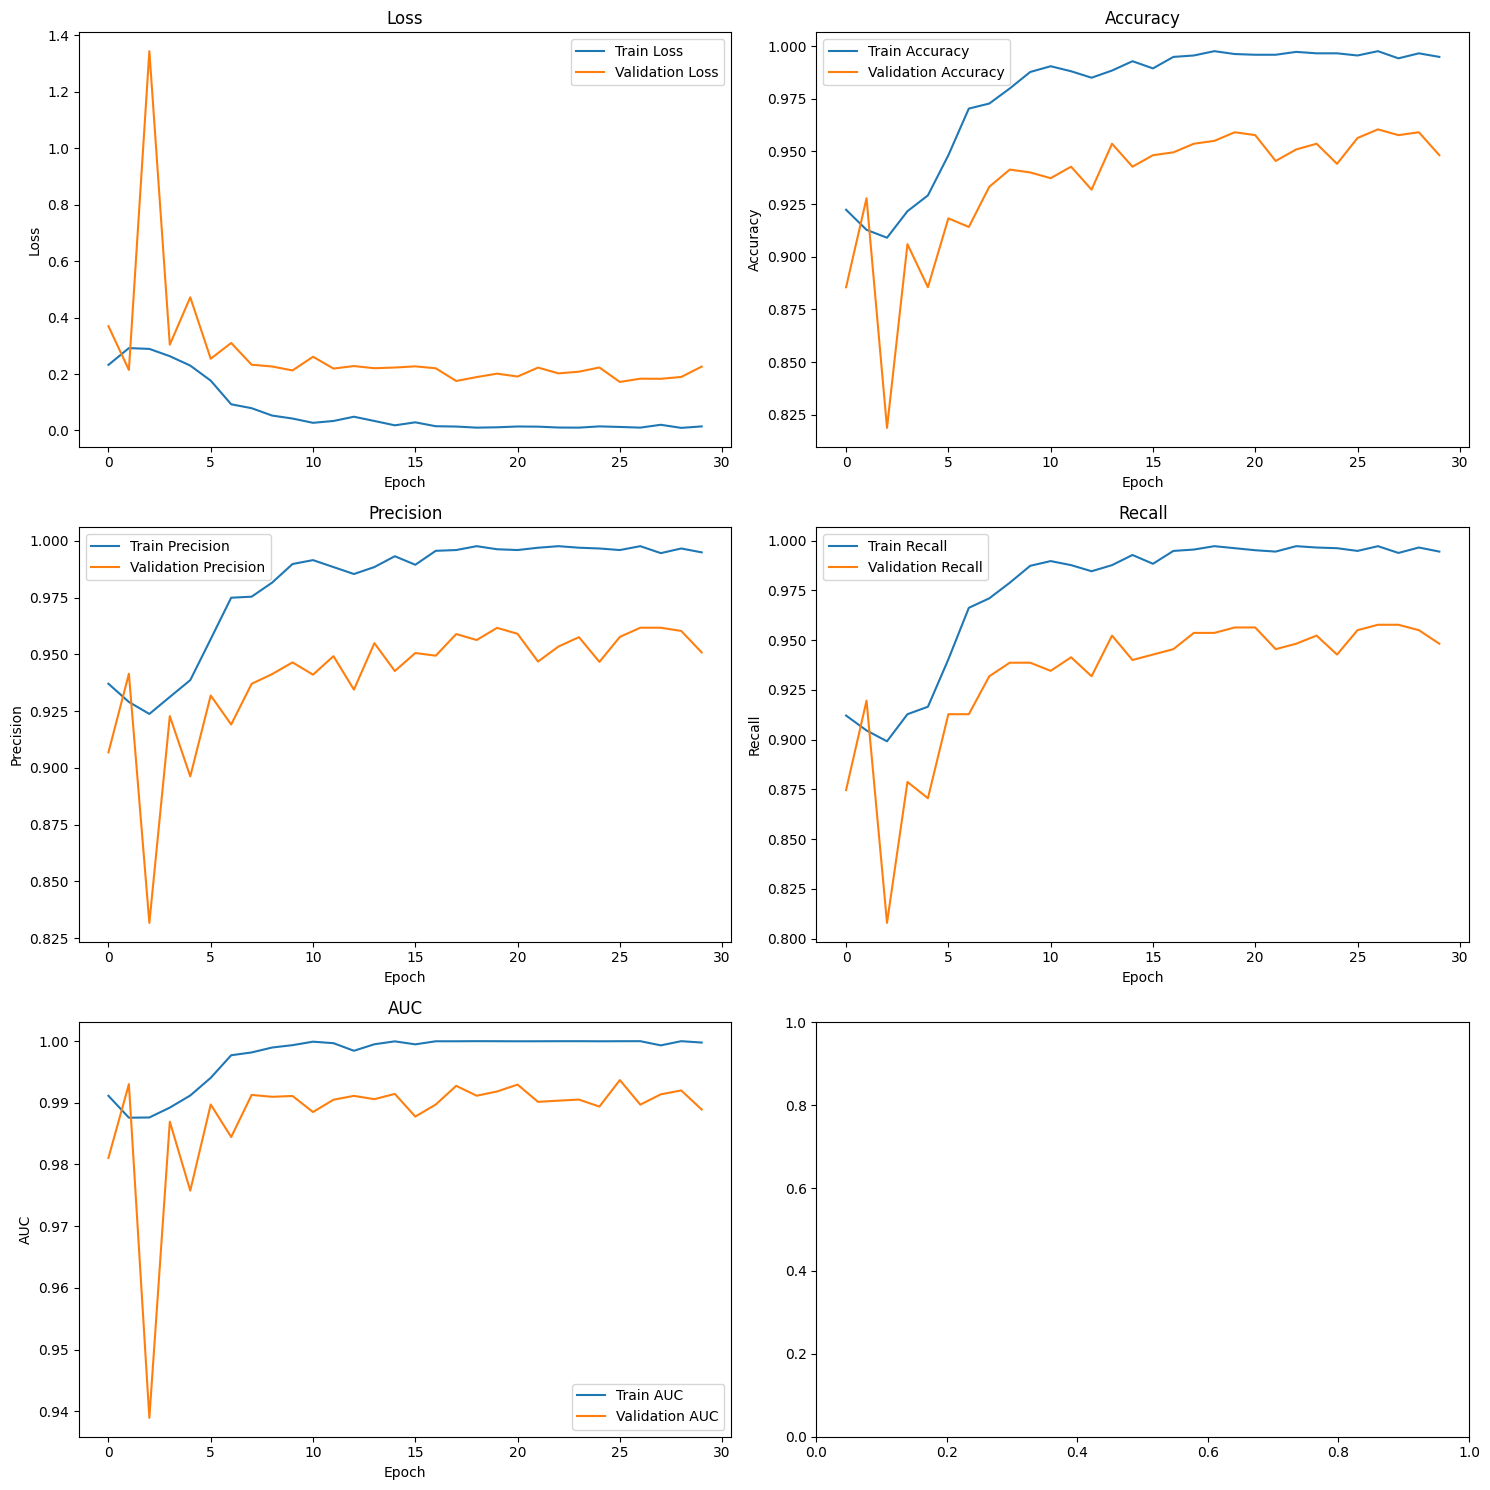

In [28]:
import matplotlib.pyplot as plt

def plot_curves(history):
    """Plots training curves for loss, accuracy, precision, recall, and AUC."""

    fig, axes = plt.subplots(3, 2, figsize=(15, 15))  # Create a 3x2 grid of subplots
    axes = axes.flatten()  # Flatten the axes array for easier access

    # Plot Loss
    axes[0].plot(history.history['loss'], label='Train Loss')
    axes[0].plot(history.history['val_loss'], label='Validation Loss')
    axes[0].set_title('Loss')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Loss')
    axes[0].legend()

    # Plot Accuracy
    axes[1].plot(history.history['acc'], label='Train Accuracy')
    axes[1].plot(history.history['val_acc'], label='Validation Accuracy')
    axes[1].set_title('Accuracy')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Accuracy')
    axes[1].legend()

    # Plot Precision
    # The key for precision might be 'precision_1' if you are using
    # tf.keras.metrics.Precision() without specifying a name.
    # Check the keys in history.history to confirm the actual key name.
    precision_key = 'precision_1'  # Replace with the correct key if needed
    axes[2].plot(history.history[precision_key], label='Train Precision')
    axes[2].plot(history.history['val_' + precision_key], label='Validation Precision')
    axes[2].set_title('Precision')
    axes[2].set_xlabel('Epoch')
    axes[2].set_ylabel('Precision')
    axes[2].legend()

    # Plot Recall
    # Similar to precision, the key for recall might be 'recall_1'
    # Check the keys in history.history to confirm the actual key name.
    recall_key = 'recall_1' # Replace with the correct key if needed
    axes[3].plot(history.history[recall_key], label='Train Recall')
    axes[3].plot(history.history['val_' + recall_key], label='Validation Recall')
    axes[3].set_title('Recall')
    axes[3].set_xlabel('Epoch')
    axes[3].set_ylabel('Recall')
    axes[3].legend()

    # Plot AUC
    # Similar to precision and recall, the key for auc might be 'auc_1'
    # Check the keys in history.history to confirm the actual key name.
    auc_key = 'auc_1' # Replace with the correct key if needed
    axes[4].plot(history.history[auc_key], label='Train AUC')
    axes[4].plot(history.history['val_' + auc_key], label='Validation AUC')
    axes[4].set_title('AUC')
    axes[4].set_xlabel('Epoch')
    axes[4].set_ylabel('AUC')
    axes[4].legend()

    plt.tight_layout()
    plt.show()

# Call the function to plot the curves
plot_curves(history)

In [16]:
early_stopping = EarlyStopping(
    patience=10,
    min_delta=0,
    # mode=min,
    monitor='val_loss',
    verbose=0,
    restore_best_weights=True,
    baseline=None
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    min_lr=1e-7
)

# Training

In [27]:
history = model.fit(train_generator, epochs = 30, validation_data = validation_generator, callbacks = [early_stopping, reduce_lr])

Epoch 1/30
184/184 ━━━━━━━━━━━━━━━━━━━━ 62s 329ms/step - acc: 0.9315 - auc_1: 0.9931 - loss: 0.1986 - precision_1: 0.9453 - recall_1: 0.9225 - val_acc: 0.8856 - val_auc_1: 0.9811 - val_loss: 0.3695 - val_precision_1: 0.9068 - val_recall_1: 0.8747 - learning_rate: 0.0010
Epoch 2/30
184/184 ━━━━━━━━━━━━━━━━━━━━ 82s 325ms/step - acc: 0.9199 - auc_1: 0.9884 - loss: 0.2882 - precision_1: 0.9337 - recall_1: 0.9120 - val_acc: 0.9278 - val_auc_1: 0.9930 - val_loss: 0.2143 - val_precision_1: 0.9414 - val_recall_1: 0.9196 - learning_rate: 0.0010
Epoch 3/30
184/184 ━━━━━━━━━━━━━━━━━━━━ 61s 325ms/step - acc: 0.9182 - auc_1: 0.9906 - loss: 0.2481 - precision_1: 0.9302 - recall_1: 0.9092 - val_acc: 0.8188 - val_auc_1: 0.9389 - val_loss: 1.3438 - val_precision_1: 0.8317 - val_recall_1: 0.8079 - learning_rate: 0.0010
Epoch 4/30
184/184 ━━━━━━━━━━━━━━━━━━━━ 82s 319ms/step - acc: 0.9198 - auc_1: 0.9912 - loss: 0.2404 - precision_1: 0.9318 - recall_1: 0.9125 - val_acc: 0.9060 - val_auc_1: 0.9870 - val_lo

# Plots